# <center> Module 5

Group: 12<br>
Darko Petrov<br>
Alexander Lendon

# Q1.
##### (a)
We start with the potential function $\Psi_0(x) = \frac{1}{2}\|x - x^*\|^2$. We want to show that:

$$
\Psi_0(x_{t+1}) - \Psi_0(x_t) = \mu \nabla^T f(x_t)(x^* - x_t) + \frac{1}{2} \|x_{t+1} - x_t\|^2
$$

The expressions for $ \Psi_0 $ are as follows:
$$
    \Psi_0(x^{(t+1)}) = \frac{1}{2}||x^{(t+1)}-x^{*}||^2
$$
$$
    \Psi_0(x^{(t)}) = \frac{1}{2}||x^{(t)}-x^{*}||^2
$$
Using these two to formulate the difference in $\Psi$ value on the left hand side of the expression
$$
    \Psi_0(x^{(t+1)}) - \Psi_0(x^{(t)}) = \frac{1}{2}||x^{(t+1)}-x^{*}||^2 - \frac{1}{2}||x^{(t)}-x^{*}||^2
$$
Substitute in the expression for $x^{(t+1)}$ to get everything in terms of $x^{(t)}$
$$
    \Psi_0(x^{(t+1)}) - \Psi_0(x^{(t)}) = \frac{1}{2}||x^{(t)}-\mu \nabla f(x_t)-x^{*}||^2 - \frac{1}{2}||x^{(t)}-x^{*}||^2
$$
expand the squared norm
$$
    ||x^{(t)}-\mu \nabla f(x_t)-x^{*}||^2 = ||x^{(t)}-x^{*}||^2 +||+\mu \nabla f(x_t)||^2 - 2\mu\nabla f(x^{(t)})(x^{(t)}-x^{*})
$$
substitute this back into the expression and simplify
$$
    \Psi_0(x^{(t+1)}) - \Psi_0(x^{(t)}) = \frac{1}{2}\left[||x^{(t)}-x^{*}||^2 +||-\mu \nabla f(x_t)||^2 - 2\mu\nabla f(x^{(t)})(x^{(t)}-x^{*})\right] - \frac{1}{2}||x^{(t)}-x^{*}||^2
$$
and simplify
$$
    \Psi_0(x^{(t+1)}) - \Psi_0(x^{(t)}) = \frac{1}{2}||-\mu \nabla f(x_t)||^2 - \mu\nabla f(x^{(t)})(x^{(t)}-x^{*})
$$
Using equation (1), $x_{t+1} = x_t - \mu \nabla f(x_t)$, to express $x_{t+1} - x_t$ in terms of the gradient:
$$
-\mu \nabla f(x_t) = x_{t+1} - x_t
$$
Substituting the gradient in the first part and bringing the negative into the other part of the equation gives the final result.
$$
    \Psi_0(x^{(t+1)}) - \Psi_0(x^{(t)}) =  \mu\nabla f(x^{(t)})(x^{*}-x^{(t)}) + \frac{1}{2}||x_{t+1} - x_t||^2 
$$

##### (b)

## Q2.

Finished N=16176
Finished N=40440
Finished N=80880


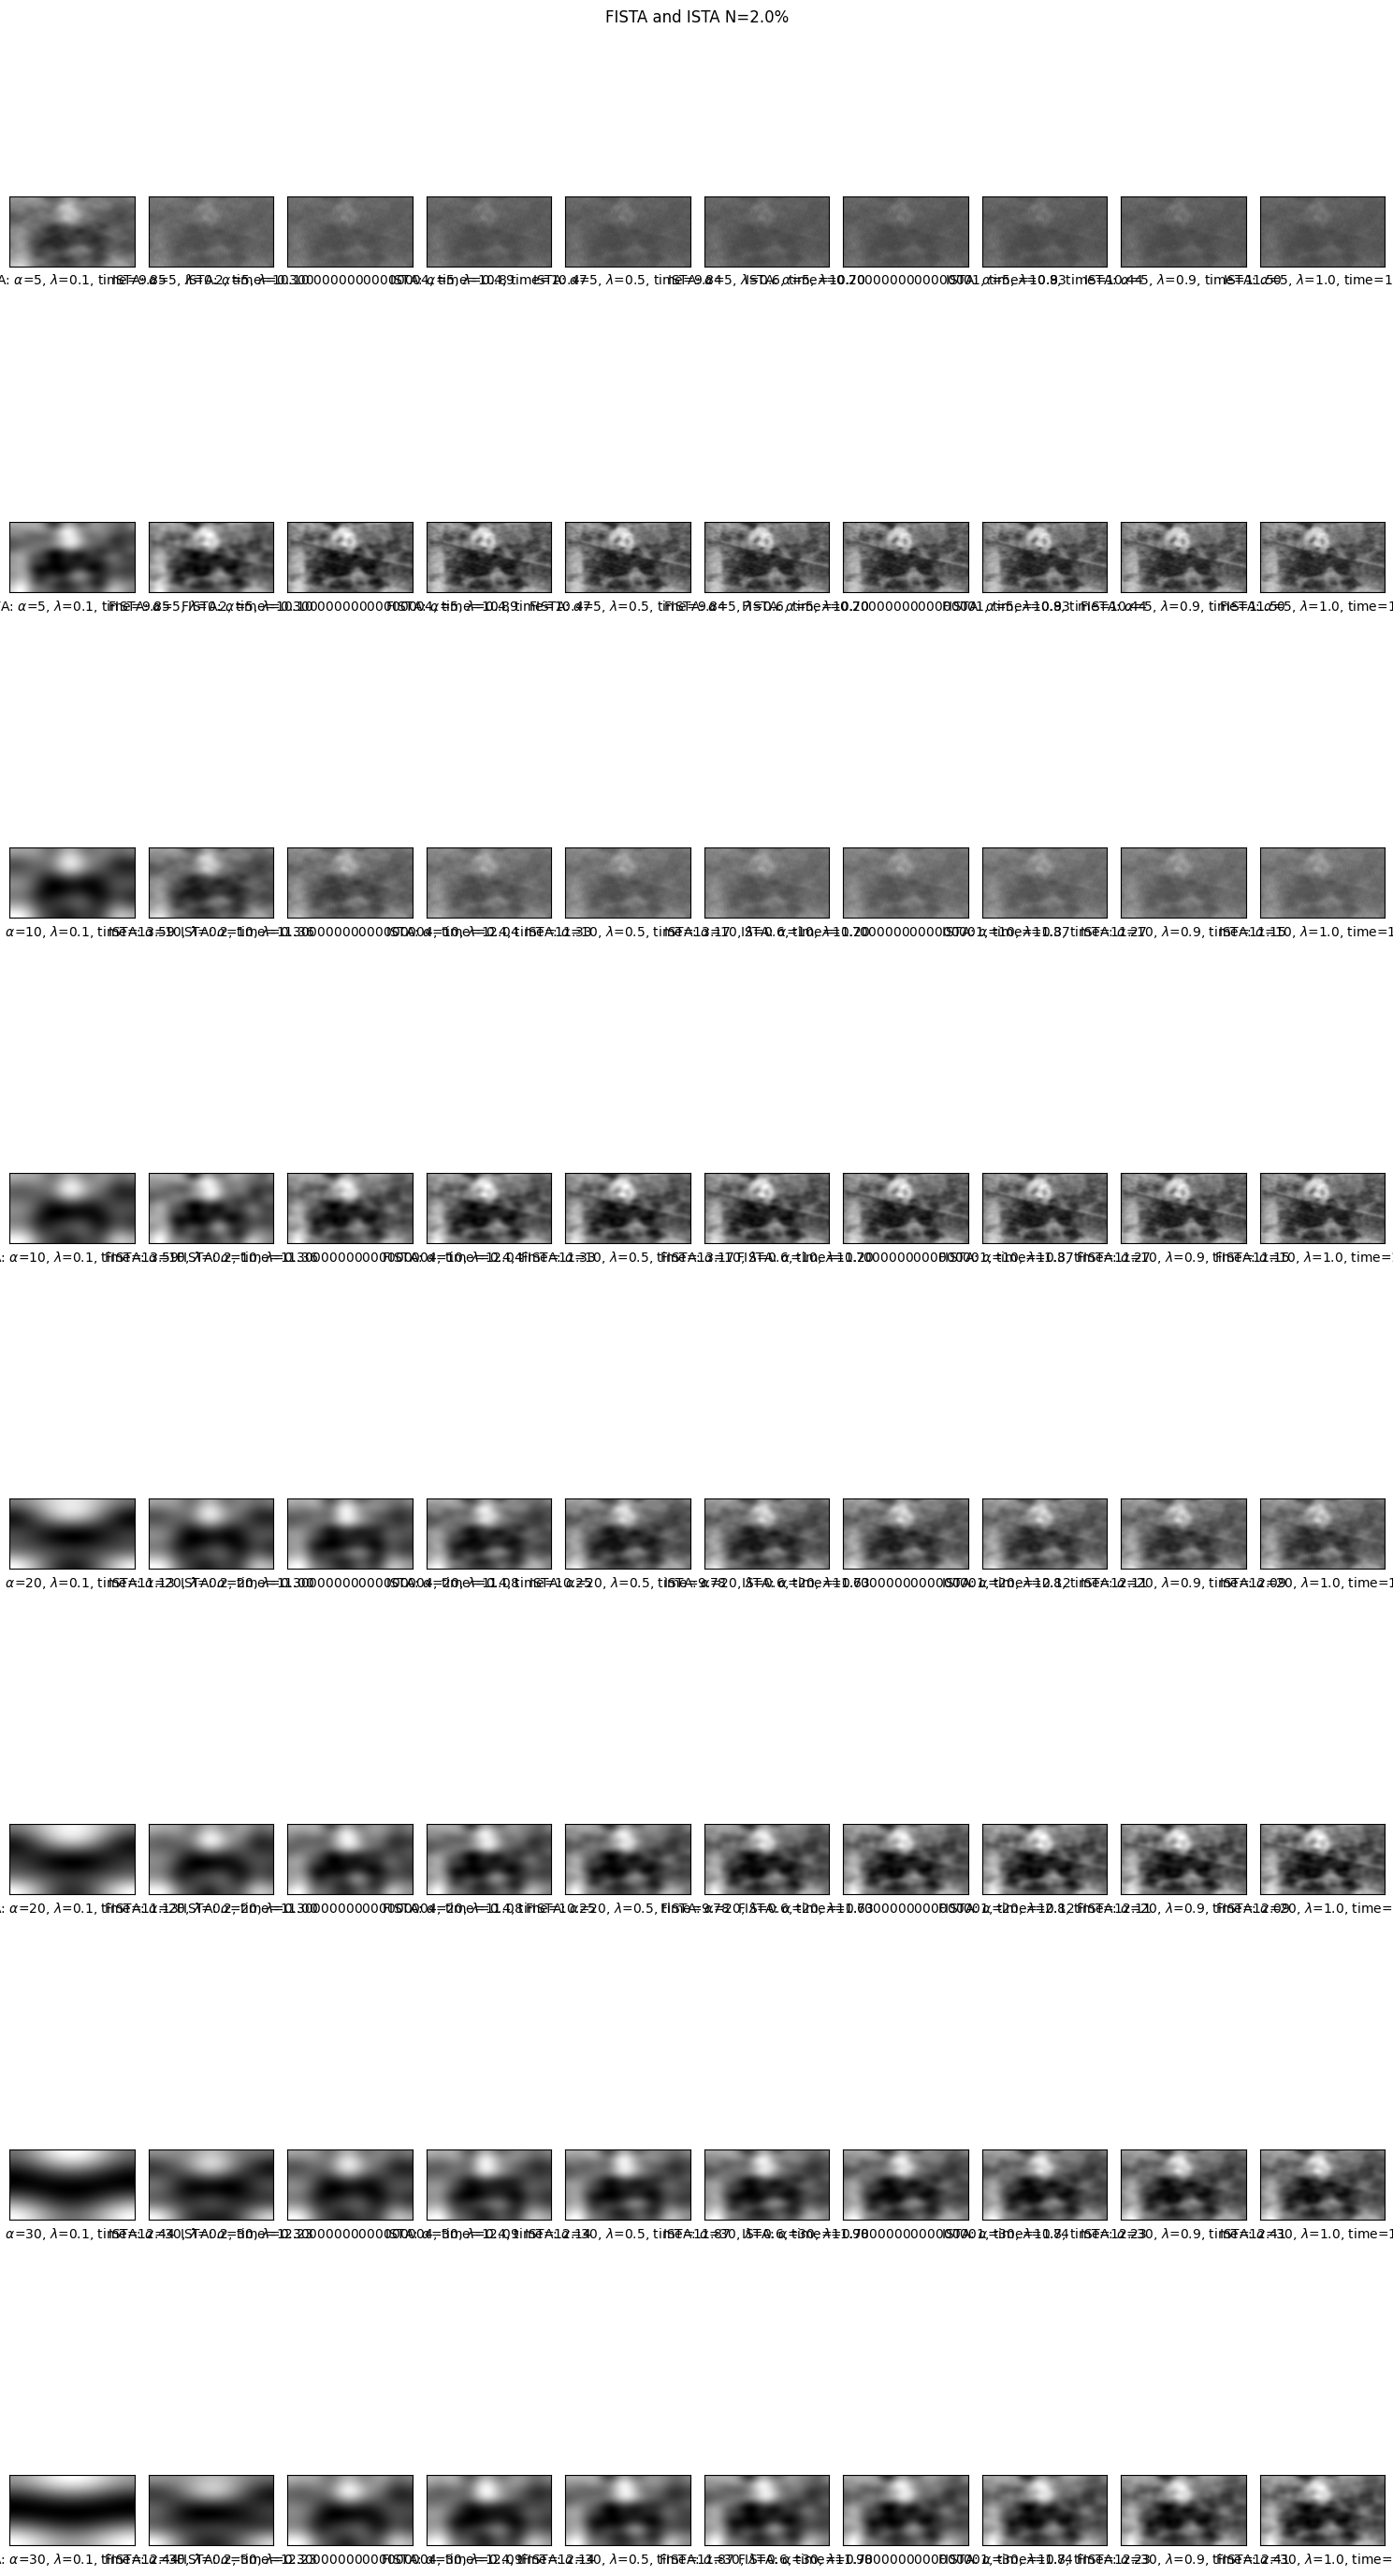

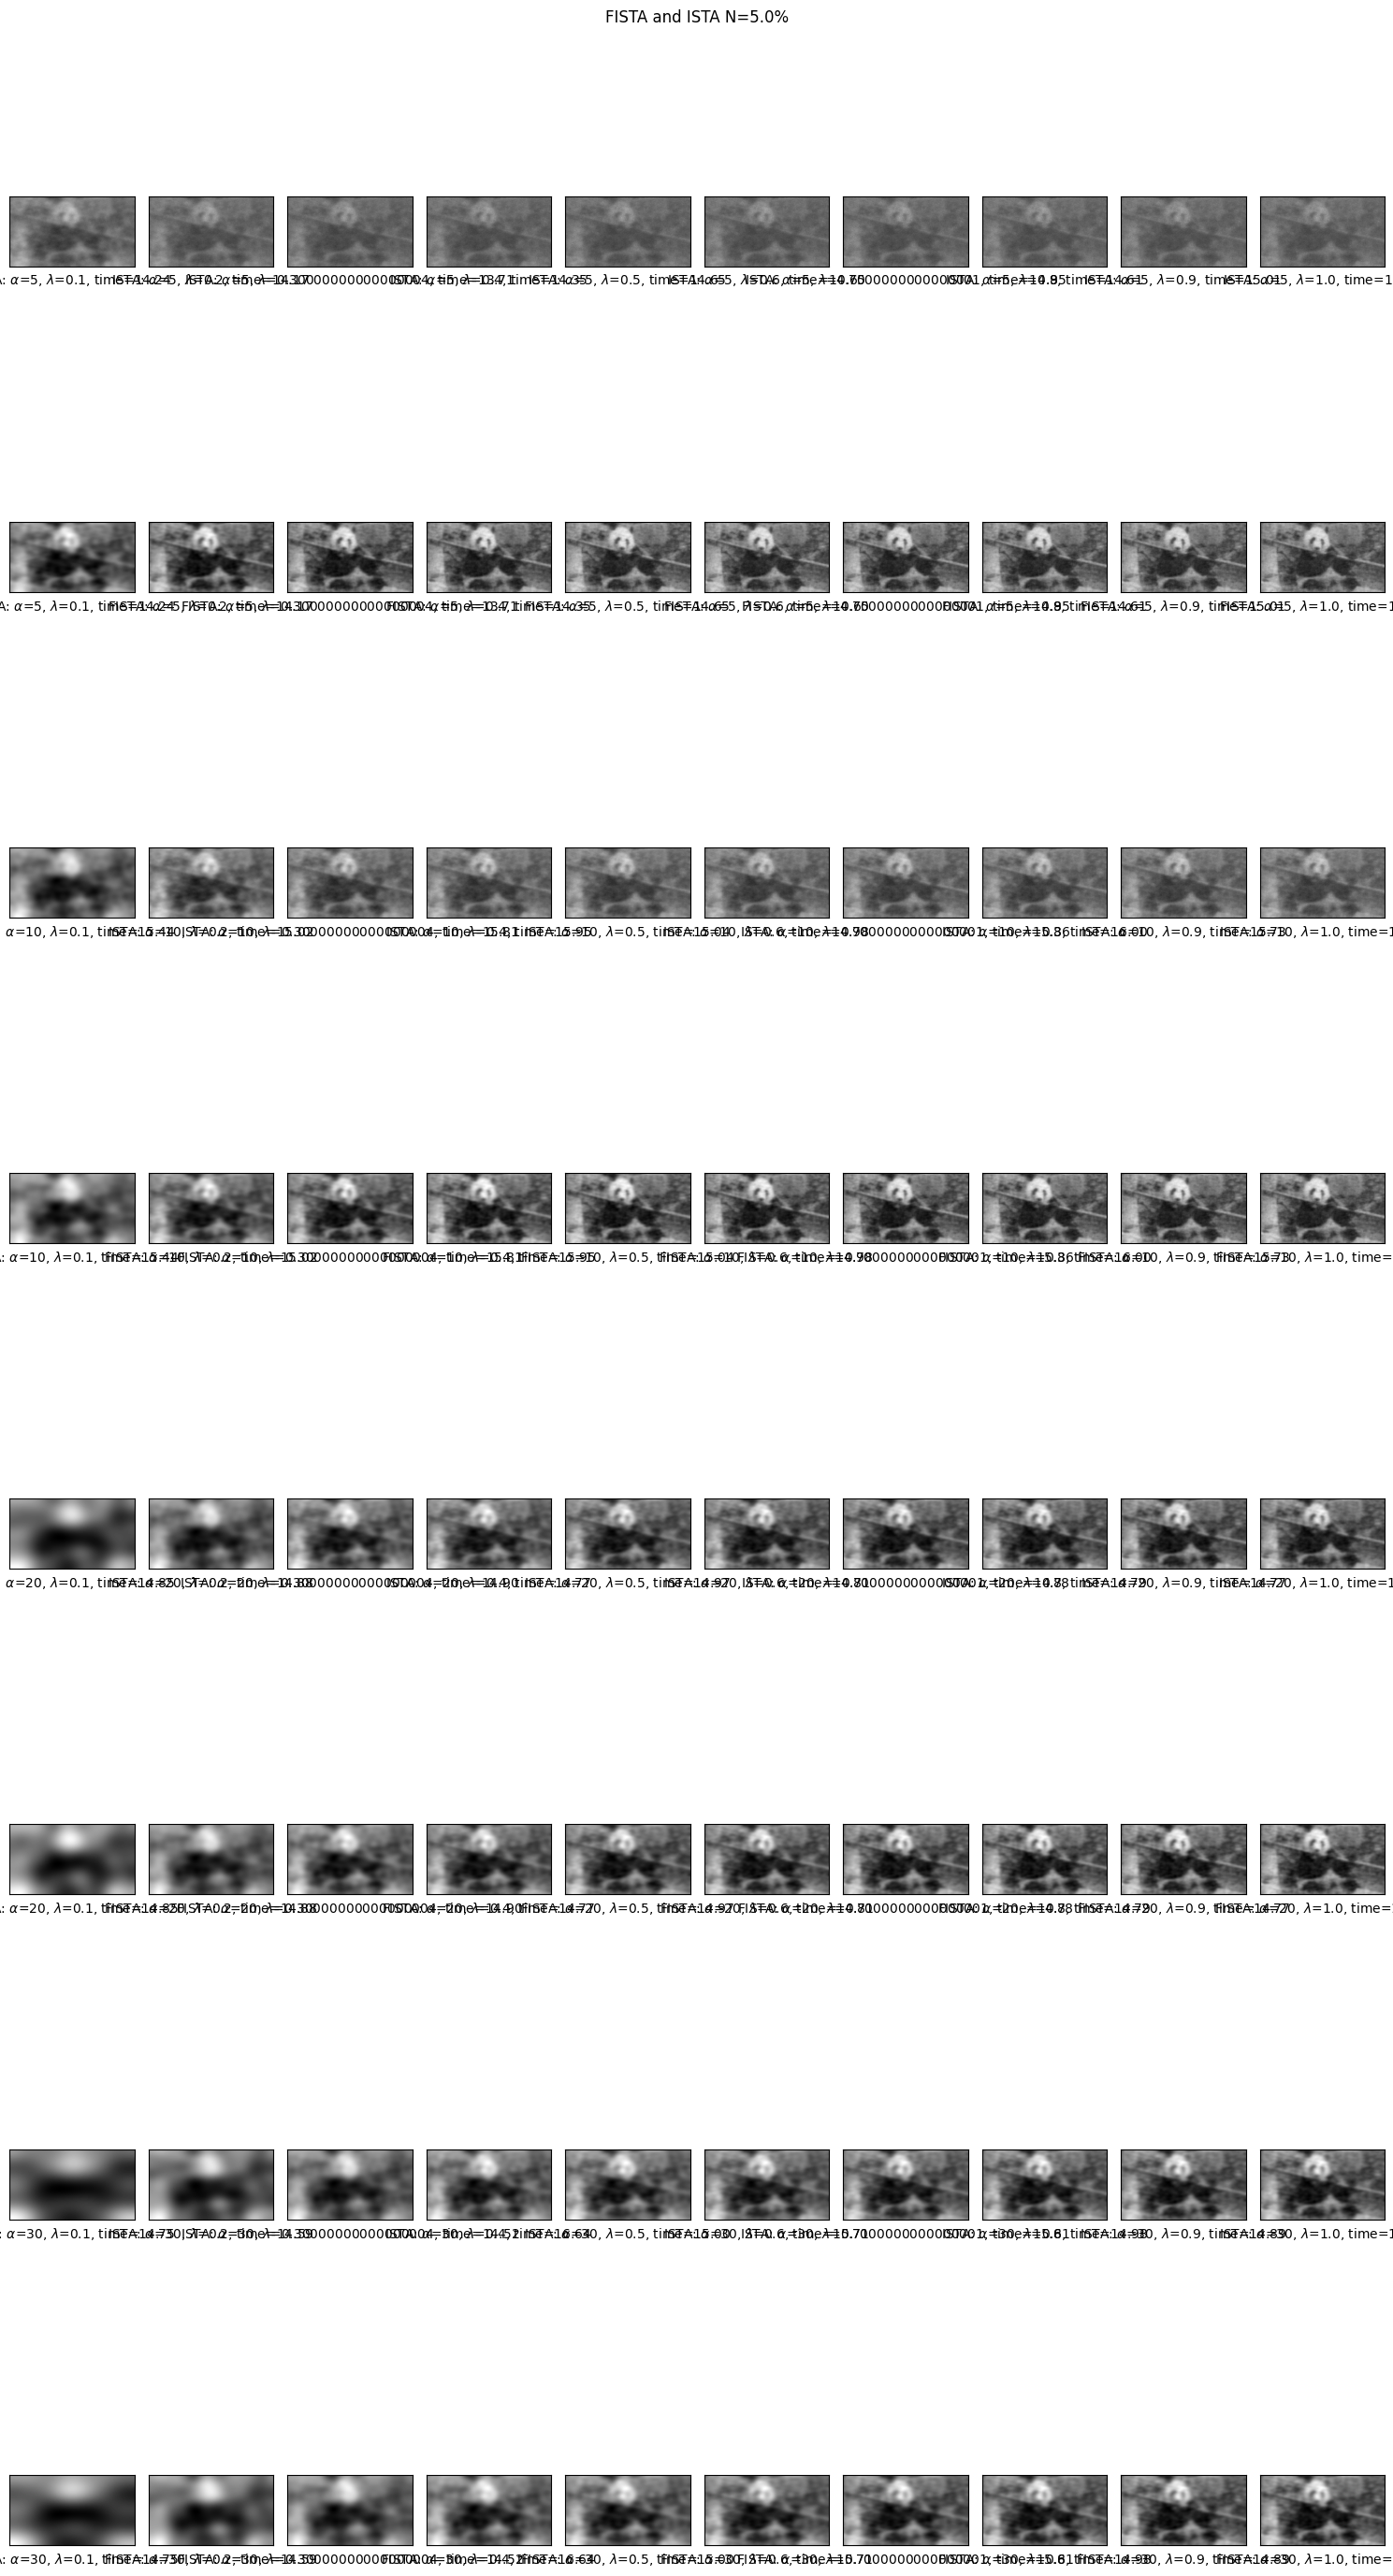

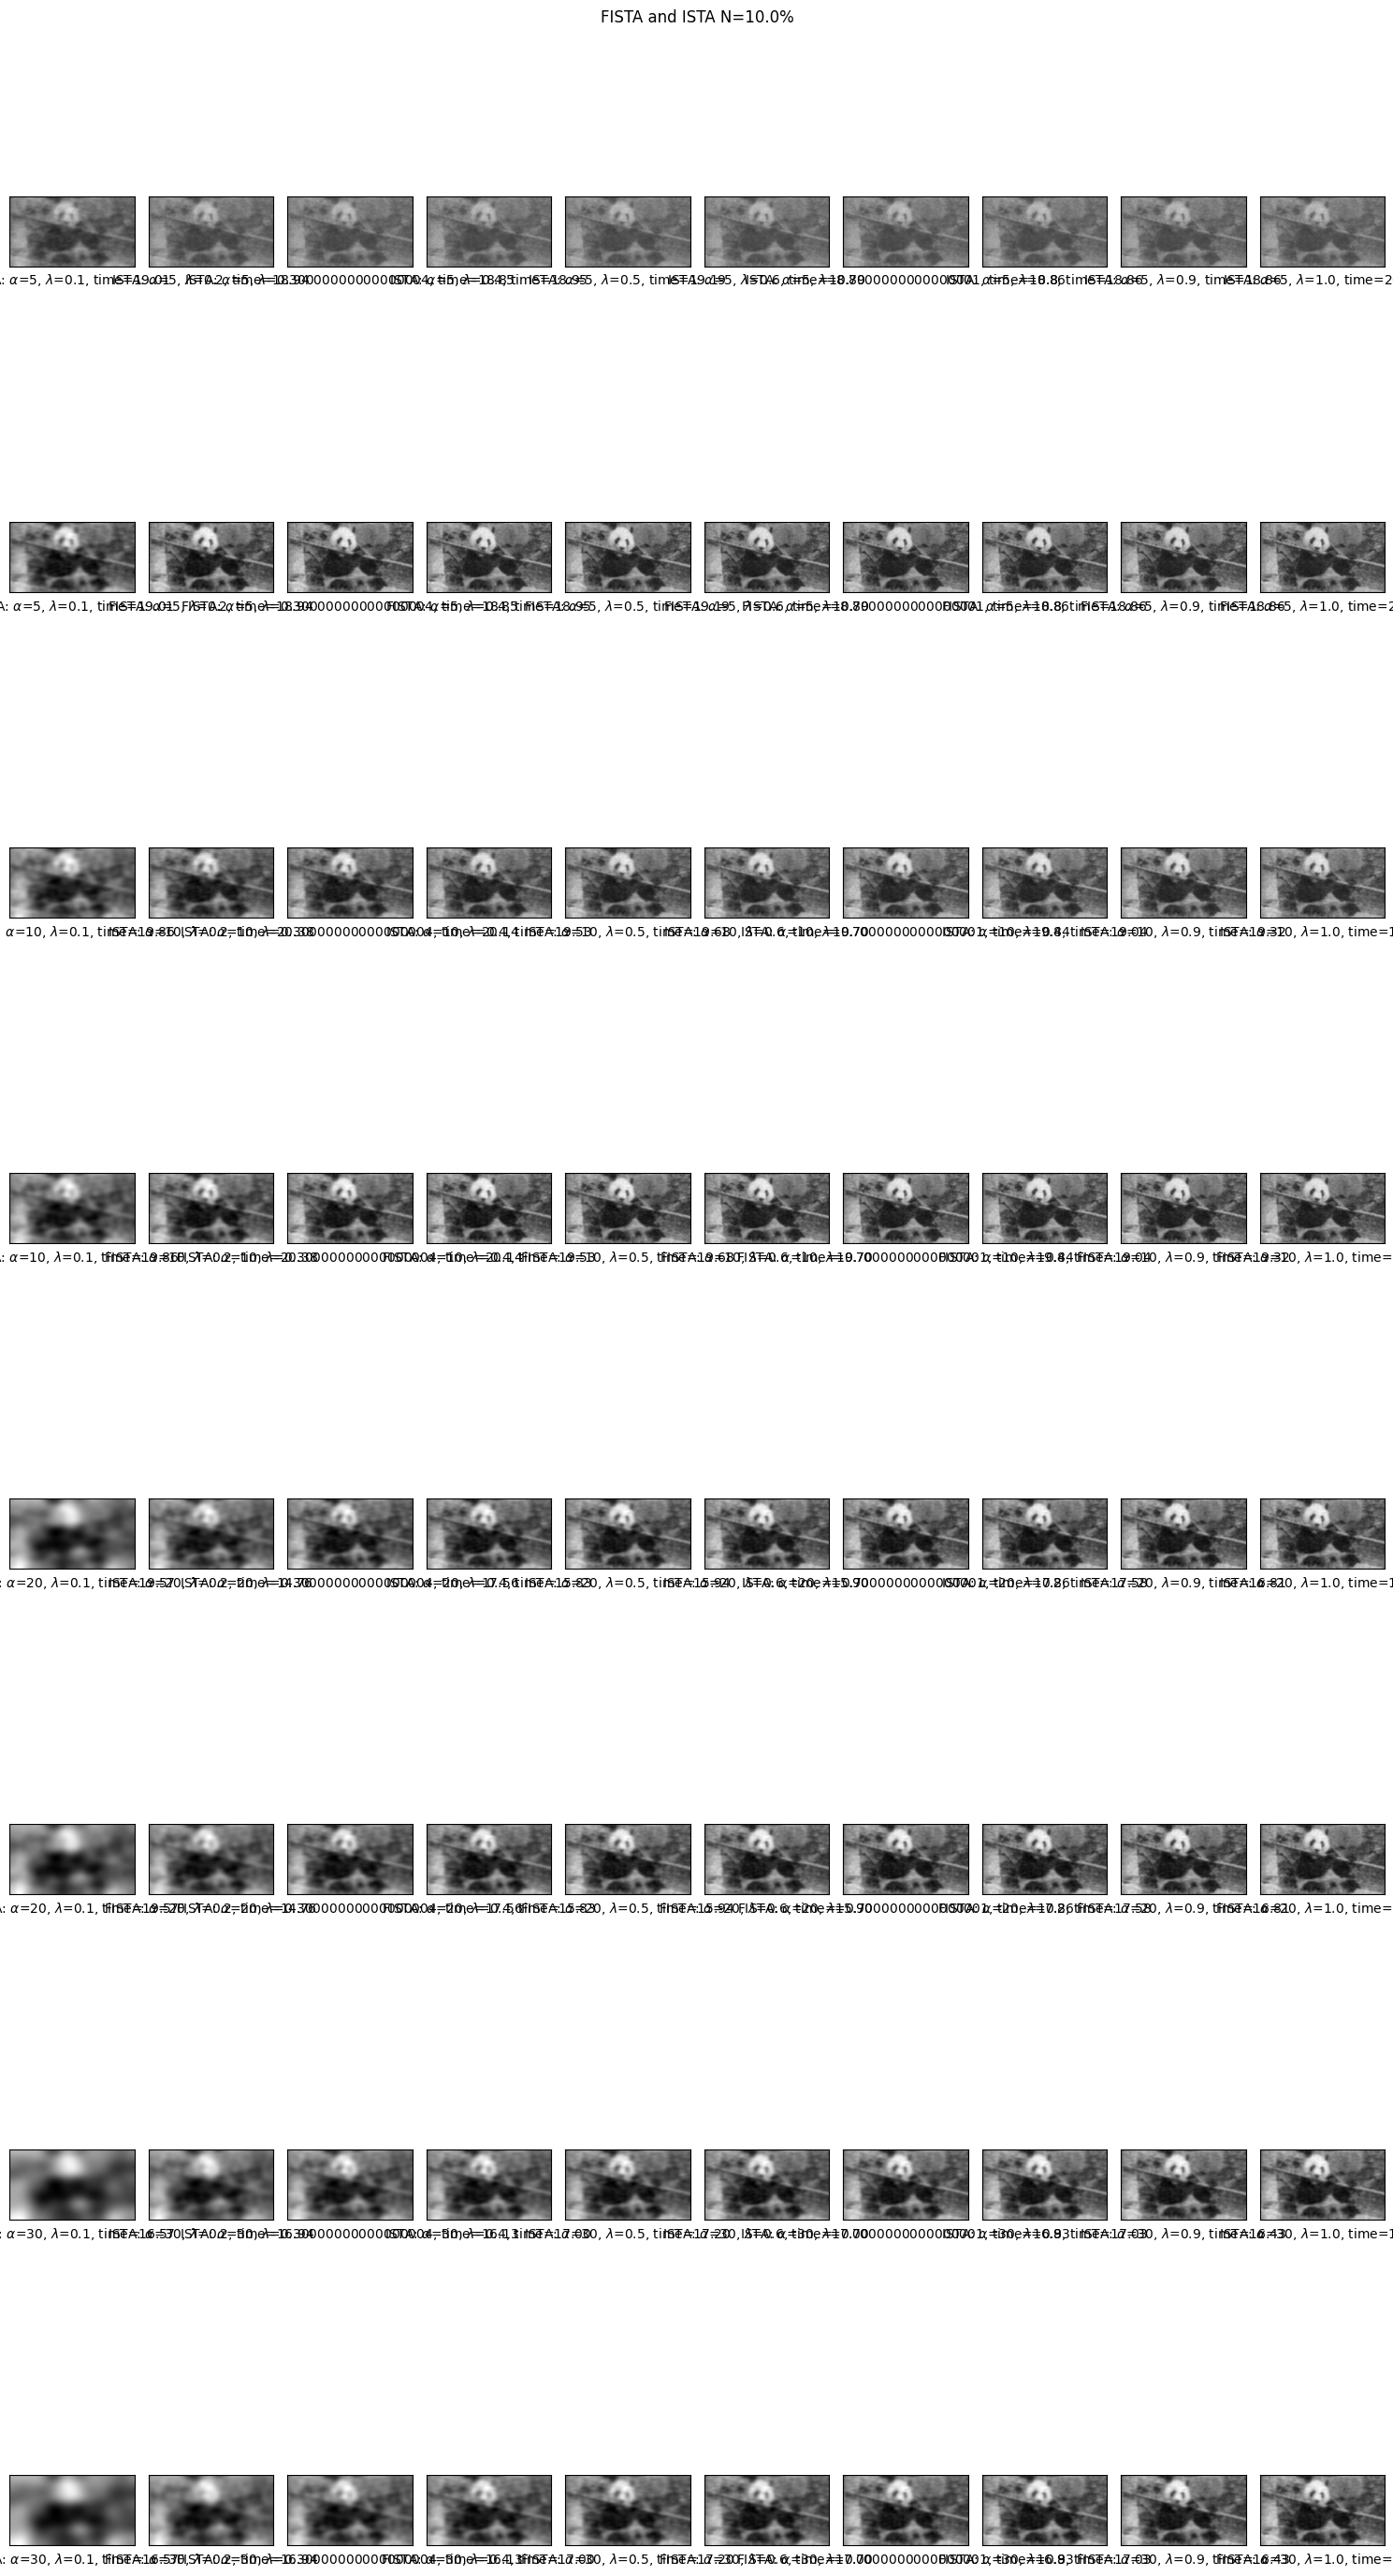

In [68]:
import imageio.v2 as iio
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as transform
import time
import pickle
import os

img = iio.imread("panda.png")
# generating grayscale image:
bw_img=np.sum(img,2)/3
N = bw_img.shape[0]*bw_img.shape[1]
# Take a number sample_num of samples and generate their
# horizontal and vertical coordinates (indicies) randomly in arrays xcoord, ycoord
sample_num = int(N * 0.05)  # 5% of N
xcoord = np.random.randint(0, bw_img.shape[0], sample_num)
ycoord = np.random.randint(0, bw_img.shape[1], sample_num)

# Store these samples in an array called y.
y = bw_img[xcoord, ycoord]

# The goal is to find the dct components x of the image from y and
# then use inverse dct to reconstruct the image.

def sq_loss_gradient(x,y, xcoord, ycoord):
    # samp_approx is Ax
    img_approx= transform.idct(transform.idct(x, axis=1, norm='ortho'),axis=0, norm='ortho')
    #print(y.shape, xcoord.shape, ycoord.shape)
    samp_approx=np.zeros(y.shape)
    for l in range(y.shape[0]):
        samp_approx[l]=img_approx[xcoord[l],ycoord[l]]

    # The following calculates e=Ax-y
    error=samp_approx-y
    img_err=np.zeros(bw_img.shape)
    for l in range(y.shape[0]):
        img_err[xcoord[l],ycoord[l]]=error[l]
    # This calculates A^Te which is the gradient 
    grad=transform.dct(transform.dct(img_err, axis=0, norm='ortho'),axis=1, norm='ortho')

    return grad, samp_approx

def shrinkage(x,alpha):
    # Implement the shrinkage operator which is the proximal operator
    # of the regularizer
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)
    
def calculate_obj_ISTA(x, y, Ax, lamb):
    return np.sum((y - Ax) + lamb*np.linalg.norm(x))

def ISTA(y, xcoord, ycoord, alpha, xinit, step=0.99, iternum=100):
    # Implement the iteration and also calculate the objective value and
    # the vaue of the regularization term at each iteration
    # Calculate the gradient
    # Initialization:
    x = []  # Initialize x
    x.append(xinit)  # x[0] is the initial point
    obj_val = []
    
    for iter in range(iternum):
        grad, Ax = sq_loss_gradient(x[-1], y, xcoord, ycoord)
        x_hat = x - step*grad
        x  = shrinkage(x_hat, alpha)
        obj_val.append(calculate_obj_ISTA(x, y, Ax, step))
    return x[-1]

def FISTA(y, xcoord, ycoord, alpha, xinit, step=0.99, iternum=100):
    # Initialization:
    x = xinit  # Initialize x
    x_prev = xinit  # Initialize x_prev
    z = xinit.copy()  # Initialize z
    t = 1  # Initialize t
    t_prev = 1  # Initialize t_prev

    for iter in range(iternum - 1):
        # Compute the gradient at z
        grad, _ = sq_loss_gradient(z, y, xcoord, ycoord)

        # Update x
        x = shrinkage(z - step * grad, alpha)

        # Update t
        t = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2

        # Update z
        z = x + ((t_prev - 1) / t) * (x - x_prev)

        # Update x_prev and t_prev for the next iteration
        x_prev = x
        t_prev = t

    return x

# run ISTA/FISTA and generate the approximate DCT coefficients x
# Then, generate the recovered image
#aplha is related to the step size and a regularisation parameter

alpha = 10
lambd = float(0.99)
def plotfirst2(alpha,lambd):
    x_ISTA = ISTA(y, xcoord, ycoord, alpha, np.zeros(bw_img.shape), lambd, iternum=100)
    img_approx_ISTA = transform.idct(transform.idct(x_ISTA, axis=1),axis=0, norm='ortho')

    x_FISTA = FISTA(y, xcoord, ycoord, alpha, np.zeros(bw_img.shape), lambd, iternum=100)
    img_approx_FISTA = transform.idct(transform.idct(x_FISTA, axis=1),axis=0, norm='ortho')

    # Plot the result
    fig = plt.figure()    
    plt.imshow(img_approx_ISTA, cmap='gray')
    fig.show()

    # Plot the result
    fig = plt.figure()    
    plt.imshow(img_approx_FISTA, cmap='gray')
    fig.show()
def investigateParams(N=N):
    # Investigate effect of N and lambda on the quality of the reconstruction
    # Define the range of N values and alpha values to test
    N_perc = [ 0.02, 0.05, 0.1]
    N_values = [int(N * perc) for perc in N_perc]
    lambda_values = np.linspace(0.1, 1, 10)
    alpha_values = [5, 10, 20, 30]

    # Initialize lists to store the results
    results_ISTA = []
    results_FISTA = []
    time_ISTA = []
    time_FISTA = []

    if not os.path.exists('results.pickle'):
        # Loop over the N values
        for sample_num in N_values:
            # Generate the samples for this N value        
            xcoord = np.random.randint(0, bw_img.shape[0], sample_num)
            ycoord = np.random.randint(0, bw_img.shape[1], sample_num)
            y = bw_img[xcoord, ycoord]

            # Loop over the alpha and lambda values
            for alpha in alpha_values:
                for lambd in lambda_values:
                    # Run ISTA and FISTA and store the results
                    start_time = time.time()
                    x_ISTA = ISTA(y, xcoord, ycoord, alpha, np.zeros(bw_img.shape), step=lambd, iternum=100)
                    ISTA_time = time.time() - start_time

                    img_approx_ISTA = transform.idct(transform.idct(x_ISTA, axis=1),axis=0, norm='ortho')
                    results_ISTA.append(img_approx_ISTA)
                    time_ISTA.append(ISTA_time)

                    start_time = time.time()
                    x_FISTA = FISTA(y, xcoord, ycoord, alpha, np.zeros(bw_img.shape), step=lambd, iternum=100)
                    FISTA_time = time.time() - start_time
                    img_approx_FISTA = transform.idct(transform.idct(x_FISTA, axis=1),axis=0, norm='ortho')
                    results_FISTA.append(img_approx_FISTA)
                    time_FISTA.append(ISTA_time)
            print(f'Finished N={sample_num}')  # Print a message to track progress of the code
        with open('results.pickle', 'wb') as f:
            pickle.dump([results_FISTA,time_FISTA,results_ISTA,time_ISTA, N_perc, N_values, alpha_values, lambda_values], f)

    with open('results.pickle', 'rb') as f:
        data = pickle.load(f)
    results_FISTA, time_FISTA, results_ISTA, time_ISTA, N_perc, N_values, alpha_values, lambda_values = data

                   
    for i in range(len(N_values)):
        # Plot the results
        fig, axs = plt.subplots(2*len(alpha_values), len(lambda_values), figsize=(15, 30))
        fig.suptitle(f'FISTA and ISTA N={100*N_perc[i]}%')
        if len(alpha_values) == 1 and len(lambda_values) == 1:
            axs_FISTA = [[axs_FISTA]]
            axs_ISTA = [[axs_ISTA]]
          # Adjust spacing between subplots here

        for j in range(len(alpha_values)):
            for k in range(len(lambda_values)):                
                idx = i*len(alpha_values)*len(lambda_values) + j*len(lambda_values) + k
                img_ISTA = results_ISTA[idx]
                img_FISTA = results_FISTA[idx]

                axs[2*j, k].imshow(img_ISTA, cmap='gray')
                axs[2*j, k].set_xticks([])  # Hide x-axis tick values
                axs[2*j, k].set_yticks([])  # Hide y-axis tick values
                axs[2*j, k].set_xlabel(f'ISTA: $\\alpha$={alpha_values[j]}, $\\lambda$={lambda_values[k]}, time={time_ISTA[idx]:.2f}')  # Add label below the plot
                axs[2*j+1, k].imshow(img_FISTA, cmap='gray') 
                axs[2*j+1, k].set_xticks([])  # Hide x-axis tick values
                axs[2*j+1, k].set_yticks([])  # Hide y-axis tick values
                axs[2*j+1, k].set_xlabel(f'FISTA: $\\alpha$={alpha_values[j]}, $\\lambda$={lambda_values[k]}, time={time_ISTA[idx]:.2f}')  # Add label below the plot                
        plt.tight_layout()
        plt.show()
investigateParams()

## Q3.

### 1.

When $B$ is unconstrained and each column of $R$ is zero except in exactly one entry, where it is one, the $BR$ is going to become one dimentional vector with zeros everywhere except for one entry. Considering the k-means clustering objective function

$$
\arg\min_S \sum^k_{i=1} \sum_{x_j \in S_i} ||x - \mu_i||^2
$$

$BR$ becomes the same as $\mu$ vector in k-means clustering as only one dimension is going to have value and the rest are going to be zero. Therefore, the objective function becomes the same as the k-means clustering objective function.

### 2.

First we can rewrite the loss function as:

$$
L(R,B) = ||X-BR||^2_F = \frac{1}{2}tr((X-BR)^T(X-BR)) = \frac{1}{2}tr(X^TX - X^TBR - R^TB^TX + R^TB^TBR)
$$

Now we can take the derivative with respect to $R$:

$$
\frac{\partial L}{\partial R} = \frac{\partial \frac{1}{2}tr(X^TX - X^TBR - R^TB^TX + R^TB^TBR)}{\partial R}
$$

we get:

$$
\frac{\partial L}{\partial R} = \frac{-2B^TX + 2B^TBR}{2} = B^T(BR - X) 
$$

Replacing $BR - X$ with $E$ we get:

$$
\frac{\partial L}{\partial R} = B^TE
$$

Now we do the same and take the derivative with respect to $B$:


$$
\frac{\partial L}{\partial B} = \frac{\partial \frac{1}{2}tr(X^TX - X^TBR - R^TB^TX + R^TB^TBR)}{\partial B}  
$$

$$
\frac{\partial L}{\partial B} = \frac{-2XR^T + 2BR(R^T)}{2} = (BR - X)R^T
$$

We replace $BR - X$ with $E$ and we get:

$$
\frac{\partial L}{\partial B} = ER^T
$$

Converged at iteration 11694, for beta = 0.99


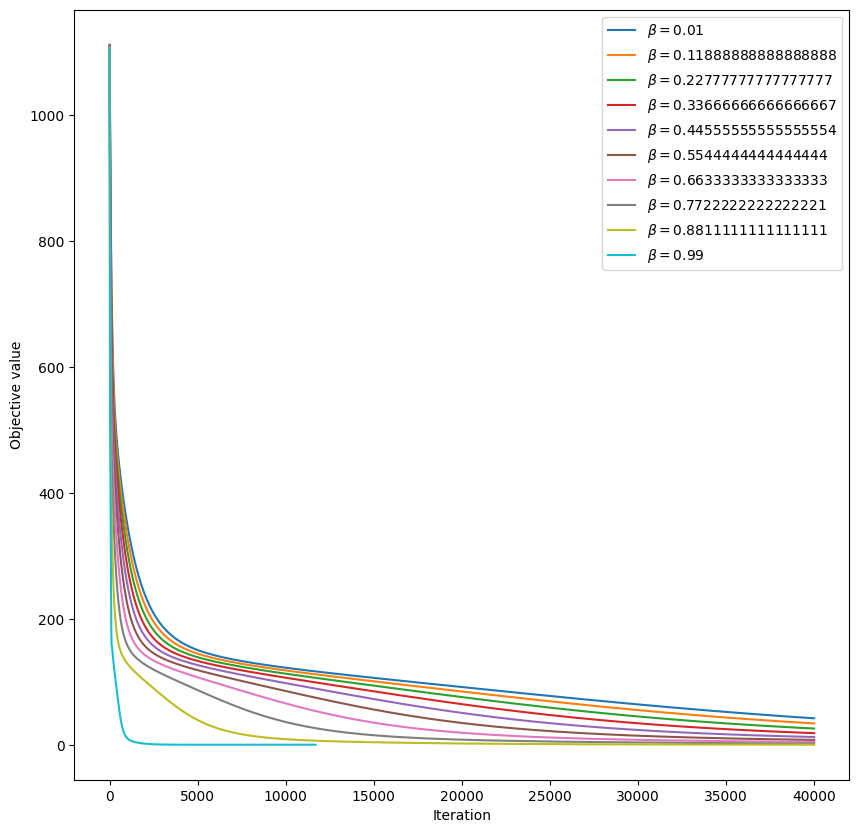

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def objective_func(b, r, X):
    return (np.linalg.norm(X-(b @ r))**2)/2


def proximal_gradient(B, R, X, beta, step_size, max_iter=40000):
    obj_val = []
    B_x = B.copy()
    R_x = R.copy()
    B_v = B.copy()
    R_v = R.copy()
    B_prev, R_prev = B, R
    
    
    for t in range(max_iter):
        E = np.dot(B, R) - X

        # Compute gradients
        dB = np.dot(E, R.T)
        dR = np.dot(B.T, E)

        B_x = B - step_size * dB
        R_x = R - step_size * dR
        
        
        B_v = B_x + beta * (B_x - B_prev)
        R_v = R_x + beta * (R_x - R_prev)
                
        if objective_func(B_x, R_x, X) <= objective_func(B_v, R_v, X):
            B = B_x
            R = R_x
            
        else:
            B = B_v
            R = R_v

        # Compute the objective value
        obj_val.append(objective_func(B, R, X))
        
        B_prev, R_prev = B_x, R_x
        # Check for convergence
        if t > 0 and np.abs(obj_val[-1] - obj_val[-2]) < 1e-10:
            print(f'Converged at iteration {t}, for beta = {beta}')
            break
        

    return B, R, obj_val


# Generate the true matrices B and R
np.random.seed(2)
B_true = np.random.choice([0, 1], size=(10, 20), p=[0.5, 0.5])
R_true = np.random.uniform(0, 1, size=(20, 100))

# Generate the observed matrix X
X = B_true @ R_true

# Initialize B and R randomly
B_init = np.random.uniform(0, 1, size=(10, 20))
R_init = np.random.uniform(0, 1, size=(20, 100))

betas = np.linspace(0.01,0.99,10)

plt.figure(figsize=(10, 10))
for beta in betas:
    # Run the proximal gradient method
    B_est, R_est, losses = proximal_gradient(B_init, R_init, X, beta, step_size=1e-5)

    # Plot the convergence of the algorithm
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
plt.legend([f'$\\beta = {beta}$' for beta in betas])
plt.show()




### 3.

(a) 

The results differ as B and R are initialized randomly, but they all converge the same way and the end results are the same for all realizations. 

(b)

The best $\beta$ value for minimizing L is as close to 1 as in the plot above beta 0.99 converges the fastest and has the lowest loss value. 